In [9]:
import tensorflow as tf
from keras.datasets import mnist
import tensorflow_datasets.image_classification.caltech_birds as caltech_birds
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
from keras import backend as K
from sklearn.model_selection import train_test_split

#K.tensorflow_backend.set_image_dim_ordering('th')
K.set_image_data_format('channels_last')

%matplotlib inline

seed = 7
np.random.seed(seed)

In [10]:
import h5py

target_size = (200, 200)
target_dims = (200, 200, 1) # add channel for RGB
num_classes = 5

# Função para verificar GPUs disponíveis
def get_available_gpus():
    gpus = tf.config.list_physical_devices('GPU')
    return [gpu.name for gpu in gpus] if gpus else []

def load_local_dataset(dataset_path, target_size=(200, 200)):
    classes = sorted(os.listdir(dataset_path))  # Obtém a lista de classes (pastas A, E, I, O, U)
    images, labels = [], []
    
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Carrega em escala de cinza
            if img is None:
                continue
            img = cv2.resize(img, target_size)  # Redimensiona
            images.append(img)
            labels.append(label)
    
    images = np.array(images, dtype=np.float32) / 255.0  # Normaliza para [0,1]
    labels = np.array(labels, dtype=np.int32)  # Mantém os rótulos como inteiros
    
    return images, labels

In [ ]:
dataset_path = "dataset"  # Caminho para as pastas A, E, I, O, U
output_file = "vogais_dataset.h5"

# Carrega e processa o dataset
images, labels = load_local_dataset(dataset_path)

x_train, x_test, y_train, y_test = train_test_split(
        images, labels, 
        test_size=0.1, 
        stratify=labels,
        random_state=42)

x_train = x_train.reshape(-1, *target_dims)
x_test = x_test.reshape(-1, *target_dims)

# Converte os rótulos para one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def model():
    my_model = Sequential()
    my_model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=target_dims))
    my_model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
    my_model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
    my_model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dense(num_classes, activation='softmax'))

    my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

    return my_model

(1500, 200, 200, 1)


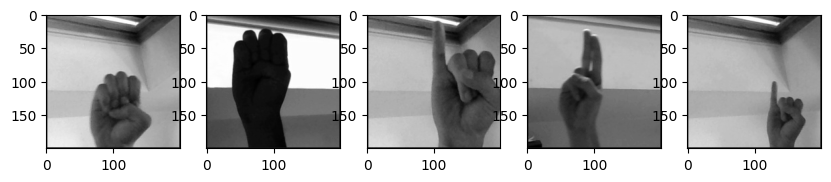

In [13]:
print(x_test.shape)
random_number = np.random.randint(0, x_train.shape[0])
fig,axes = plt.subplots(1,5,figsize=(10,100))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i + random_number].reshape(target_size), cmap='gray')

In [26]:
filename = "libravogaisneuralnet.weights.h5"
gpus = get_available_gpus()
if gpus:
    print("GPUs disponíveis:", gpus)
else:
    print("Nenhuma GPU disponível.")
model1 = model()

# Se retreinar = 1, o modelo será treinado novamente, 
# caso contrário, o modelo será carregado a partir de um arquivo .h5
retreinar = 0

epochs = 5  # para melhor resultado aumente as épocas
batch_size = 200

# Verifica se já existe um modelo treinado e exportado para um arquivo .h5
if os.path.exists(filename) and retreinar == 0:
    model1.load_weights(filename)
    print("Modelo carregado de", filename)
else:
    model1.summary()
    history = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)
    model1.save_weights(filename)


Nenhuma GPU disponível.
Modelo carregado de libravogaisneuralnet.weights.h5


In [23]:
try:
    # Trace as curvas de perda e precisão para treinamento e validação
    plt.plot(history.history['val_loss'], color='b', label="validation loss")
    plt.title("Test Loss")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
except:
    print("Modelo externo carregado. Não é possível plotar o gráfico de perda.")

Modelo externo carregado. Não é possível plotar o gráfico de perda.


In [20]:
scores = model1.evaluate(x_test, y_test, verbose=0)
print("\nacc: %.2f%%" % (scores[1]*100))


acc: 94.87%


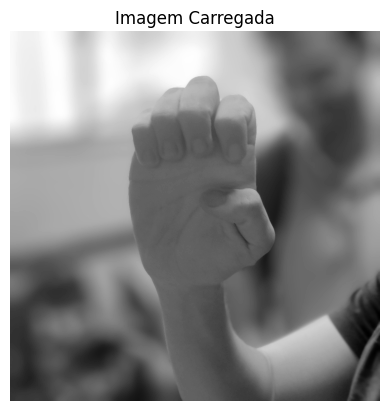

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Classe prevista: O com confiança de 98.93%


In [32]:
# Definiçao das classes
classes = ['A', 'E', 'I', 'O', 'U']

# Carregar a imagem
img_pred = cv2.imread("EdoKauan.jpg", 0)  # Carregar em escala de cinza

# Verificar se a imagem foi carregada corretamente
if img_pred is None:
    raise FileNotFoundError("A imagem não pôde ser carregada. Verifique o caminho do arquivo.")

# Exibir a imagem
plt.imshow(img_pred, cmap='gray')
plt.title("Imagem Carregada")
plt.axis('off')  # Desativar eixos
plt.show()

# Redimensionar a imagem para 28x28
img_pred = cv2.resize(img_pred, target_size)

# Adicionar dimensão do canal (para 1 canal de escala de cinza)
img_pred = np.expand_dims(img_pred, axis=-1)  # Formato (28, 28, 1)

# Adicionar dimensão do lote (1, 28, 28, 1)
img_pred = np.expand_dims(img_pred, axis=0)

# Normalizar a imagem (valores entre 0 e 1)
img_pred = img_pred.astype('float32') / 255.0

# Fazer previsões
predictions = model1.predict(img_pred)  # Obter as previsões
pred = np.argmax(predictions, axis=1)  # Obter a classe prevista
pred_proba = np.max(predictions, axis=1)  # Obter a probabilidade da classe prevista
pred_proba = "%.2f%%" % (pred_proba[0] * 100)  # Formatar a probabilidade como porcentagem

# Exibir resultados
print("Classe prevista:", classes[pred[0]], "com confiança de", pred_proba)